In [2]:
import uproot as up
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

#plt.style.use('seaborn-paper')
plt.rcParams["patch.force_edgecolor"] = True

In [3]:
file_BKG = up.open("radioactivity_userfile_7days.root")
file_IBD = up.open('ibd_userfile_7days.root')

dataset_IBD = file_IBD['TRec'].arrays(library = 'np')
dataset_BKG = file_BKG['TRec'].arrays(library = 'np')

en_fact = 0.92
dataset_IBD["m_QEn"] = dataset_IBD["m_QEn"]*en_fact 

Dataset è un DICT di NUMPY ARRAY

In [4]:
print(dataset_IBD["m_QEn"].shape)
print(dataset_BKG["m_QEn"].shape)

print(dataset_BKG["m_QEn"].shape[0]+dataset_IBD["m_QEn"].shape[0])

(704,)
(61870091,)
61870795


# Here some try

In [5]:
print([i for i in (1,2) if i == 1])
  

[1]


In [6]:
a = np.array([[1, 4]])
b = np.array([[5, 6]])
np.concatenate((a, b), axis=1)

array([[1, 4, 5, 6]])

In [7]:
def combine_dict(d1, d2):
    combined = {}
    for k in set(d1.keys()) | set(d2.keys()):
        if k in d1 and k in d2 and isinstance(d1[k], np.ndarray) and isinstance(d2[k], np.ndarray):
            combined[k] = np.concatenate([d1[k], d2[k]])
        elif k in d1:
            combined[k] = d1[k]
        else:
            combined[k] = d2[k]
    
    provenienza = np.concatenate([np.full_like(d1.get(k, []), 1), np.full_like(d2.get(k, []), 0)])
    return {**combined, 'provenienza': provenienza}

#Prova dict 
dict1 = {'t': np.array([1,2,3]), 
         'E': np.array([3,4,5])}

dict2 = {'t': np.array([4,3,1]), 
         'E': np.array([5,2,2])}

combine_dict(dict1,dict2)

{'t': array([1, 2, 3, 4, 3, 1]),
 'E': array([3, 4, 5, 5, 2, 2]),
 'provenienza': array([1, 1, 1, 0, 0, 0])}

In [8]:
combine_dict(dataset_IBD,dataset_BKG)["m_QEn"].shape

(61870795,)

In [9]:
all_data = combine_dict(dataset_IBD,dataset_BKG)

-> Dunque se viene dal dataset IBD si ha che l'evento avrà una Label di 1

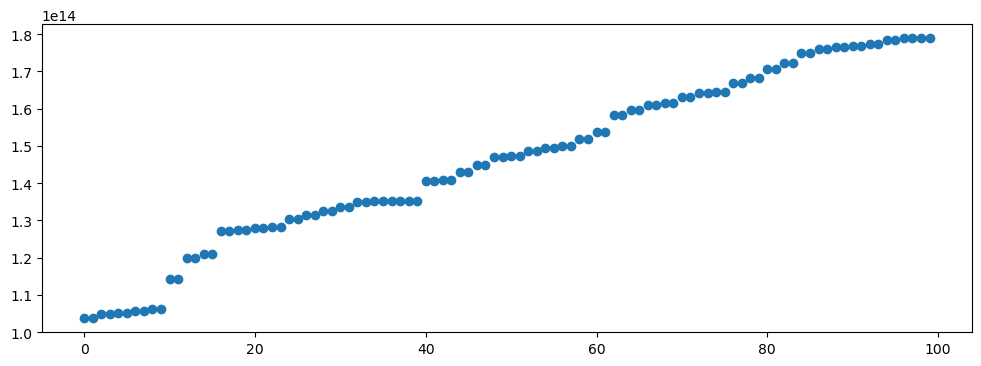

In [10]:
fig, ax = plt.subplots(figsize= (12,4))
ax.scatter(np.arange(100), all_data['m_triggerT'][100:200])

### Now I'll sort the data in temporal order

In [11]:
dicta = {'a': np.array([4.3, 2.2, 12.2, 3.1]), 'b': np.array([9, 6, 7, 8]), 'c': np.array([5, 10, 12, 11])}


Uso la funzione sort di Numpy

In [12]:
sorted_a = np.sort(dicta['a'])
sorted_a


array([ 2.2,  3.1,  4.3, 12.2])

Usa la funzione argsort di numpy per ottenere gli indici degli elementi ordinati nell'array originale:

In [13]:
idx = dicta['a'].argsort()
idx


array([1, 3, 0, 2])

In [14]:
for key in dicta.keys():
    dicta[key] = dicta[key][idx]


In [15]:
print(dicta)

{'a': array([ 2.2,  3.1,  4.3, 12.2]), 'b': array([6, 8, 9, 7]), 'c': array([10, 11,  5, 12])}


# Now for the dataset

In [16]:
ord_idx = all_data["m_triggerT"].argsort()
ord_idx

array([     704,      705,      706, ..., 61870792, 61870793, 61870794])

In [17]:
for key in all_data.keys():
    all_data[key] = all_data[key][ord_idx]

In [18]:
print(all_data["m_triggerT"])

[1.71921000e+06 1.51135350e+07 1.71738090e+07 ... 6.04799982e+14
 6.04799998e+14 6.04799999e+14]


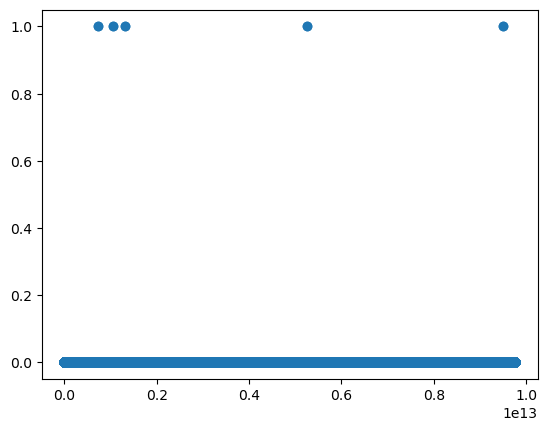

In [19]:
plt.scatter(all_data["m_triggerT"][:1000000], all_data["provenienza"][:1000000])

# Creatrion of the $\Delta r$, $\Delta t$ and label them IBD or Decay

In [20]:
print(all_data["recx"].shape[0]*2)

123741590


In [21]:
from numba import jit, njit, prange, get_num_threads

In [24]:
# @njit(parallel = False)
# def create_features(x,y,z,E,t,proven, expon_time_cut = 5 * 220e3):
#     delta_time = np.zeros(0)
#     delta_radius = np.zeros(0)
#     E_pro = np.zeros(0)
#     E_del = np.zeros(0)
#     Label = np.zeros(0)

#     for i in range(x.shape[0] - 1):
#         for j in range(i + 1 , x.shape[0] - 1): # Non devo considerare le coppie j antecedenti perchè sono state già contate da i successivi
#             if (t[j] - t[i]) < expon_time_cut: # j è l'indice del delay   
#                 delta_time = np.append(delta_time,t[j] - t[i])
#                 delta_radius = np.append(delta_radius,np.sqrt((x[i] - x[j])**2 + (y[i] - y[j])**2 + (z[i] - z[j])**2))
#                 E_pro = np.append(E_pro, E[i])
#                 E_del = np.append(E_del, E[j])
#                 if proven[i] == 1 and proven[j] == 1:
#                     Label = np.append(Label,1)
#                 else:
#                     Label = np.append(Label,0)
#             else: break
#     return delta_time, delta_radius, E_pro, E_del, Label           
                    
                
@njit(parallel = True)
def create_features_handle(x,y,z,E,t,proven, expon_time_cut = 5 * 220e3):

    # n = get_num_threads()
    n = x.shape[0] - 1

    # Creo una vettore "locale" che viene scritto/letto solo da un thread per volta -> Poichè ha la dimensione del num threads e ogni thread accede ad un np.zeros(0) a cui fare l'appending
    delta_time = n*[np.zeros(0)]
    delta_radius = n*[np.zeros(0)]
    E_pro = n*[np.zeros(0)]
    E_del = n*[np.zeros(0)] 
    Label = n*[np.zeros(0)]

    for i in prange(x.shape[0] - 1):

        #Queste due righe di sotto le faccio per risparmiarmi dei cilci
        mask = np.logical_and(t>t[i], (t - t[i]) < expon_time_cut)
        to_loop = np.nonzero(mask)[0] #-> Ritorna un vettore di indici per i quali mask ha come entrata True 
        # TIPS, usi la potenza dei np.array per fare la maschera
        
        # Non ciclo su tutti i possibili eventi, ma solo su quelli che mi possono interessare

        for t_index in range(len(to_loop)):
            j = to_loop[t_index] #-> Qui dunque j lo fai diventare già solo uno di quelli che servono

            if (t[j] - t[i]) < expon_time_cut: 

                delta_time[i] = np.append(delta_time[i],t[j] - t[i])
                delta_radius[i] = np.append(delta_radius[i],np.sqrt((x[i] - x[j])**2 + (y[i] - y[j])**2 + (z[i] - z[j])**2))
                E_pro[i] = np.append(E_pro[i], E[i])
                E_del[i] = np.append(E_del[i], E[j])
                if proven[i] == 1 and proven[j] == 1:
                    Label[i] = np.append(Label[i],1)
                else:
                    Label[i] = np.append(Label[i],0)
            else:
                print(i, j, t[j] - t[i], 'Qualcosa non va')
                break

    return delta_time, delta_radius, E_pro, E_del, Label        

from iteration_utilities import deepflatten

# Funzione per fare un flatten dell'output di Numba
def create_features(x,y,z,E,t,proven, expon_time_cut = 5 * 220e3):
    res = create_features_handle(x,y,z,E,t,proven, expon_time_cut)
    out = []
    for vec in res:
        out.append(np.asarray(list(deepflatten(vec))))      # -> deep_flatten([1, [2], [[3], 4], 5]) # [1, 2, 3, 4, 5] -> Tanto non conta l'ordine in cui hai fatto il flattern
    return out

In [26]:
features = {"delta_time": np.array([]),
            "delta_radius": np.array([]),
            "E_pro": np.array([]),
            "E_del": np.array([]), 
            "Label": np.array([])}

cut = 1000000
features["delta_time"],features["delta_radius"],features["E_pro"],features["E_del"],features["Label"] = create_features(
    all_data["recx"][:cut],
    all_data["recy"][:cut],
    all_data["recz"][:cut],
    all_data["m_QEn"][:cut],
    all_data["m_triggerT"][:cut],
    all_data["provenienza"][:cut])

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
[1m[1mNo implementation of function Function(<built-in function mul>) found for signature:
 
 >>> mul(int64, list(array(float64, 1d, C))<iv=None>)
 
There are 14 candidate implementations:
[1m      - Of which 12 did not match due to:
      Overload of function 'mul': File: <numerous>: Line N/A.
        With argument(s): '(int64, list(array(float64, 1d, C))<iv=None>)':[0m
[1m       No match.[0m
[1m      - Of which 2 did not match due to:
      Operator Overload in function 'mul': File: unknown: Line unknown.
        With argument(s): '(int64, list(array(float64, 1d, C))<iv=None>)':[0m
[1m       No match for registered cases:
        * (int64, int64) -> int64
        * (int64, uint64) -> int64
        * (uint64, int64) -> int64
        * (uint64, uint64) -> uint64
        * (float32, float32) -> float32
        * (float64, float64) -> float64
        * (complex64, complex64) -> complex64
        * (complex128, complex128) -> complex128[0m
[0m
[0m[1mDuring: typing of intrinsic-call at /tmp/ipykernel_6136/3650969193.py (31)[0m
[1m
File "../../../../../tmp/ipykernel_6136/3650969193.py", line 31:[0m
[1m<source missing, REPL/exec in use?>[0m


In [ ]:
count = 0
for i in features["Label"]:
    if i == 1:
        count = count + 1

print(count)

# Prange and parallel

In [ ]:
append_to_array()

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
[1mUntyped global name 'lock':[0m [1m[1mCannot determine Numba type of <class '_thread.lock'>[0m
[1m
File "../../../../../tmp/ipykernel_14939/3879677687.py", line 12:[0m
[1m<source missing, REPL/exec in use?>[0m
[0m